# Sketch-RNN Drawing

This notebook shows how to load pre-trained models and draw things with sketch-rnn.

It is adapted from the google project Magenta demo, to run on datahub. 

If you are having trouble with Magenta/TF 1.12 on datahub, please copy the local copy of sketch_rnn_train.py over the magenta file below (e.g. uncomment the following line and execute it)

(backup plan, [run on google colab](https://colab.research.google.com/github/tensorflow/magenta-demos/blob/master/jupyter-notebooks/Sketch_RNN.ipynb))

## Sketch-RNN Training
To train a sketch-rnn network on data from the [quickdraw dataset](https://github.com/googlecreativelab/quickdraw-dataset), (for ex: bird.npz), try this command: 

```python sketch_rnn_train.py --data_dir=datasets/quickdraw --log_root=logs/bird2 --hparams=data_set=['sketchrnn_bird.npz'],num_steps=200000,conditional=1,dec_rnn_size=1024```

More documentation on training Sketch-RNN networks is here: [Training a Model](https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/README.md#training-a-model)

In [ ]:
#!cp sketch_rnn_train.py .local/lib/python3.6/site-packages/magenta/models/sketch_rnn/sketch_rnn_train.py

In [3]:
#!pip install -qU svgwrite --user

In [6]:
#!pip install -q magenta --user

In [13]:
# import the required libraries
import numpy as np
import time
import random
import pickle as cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange



In [14]:
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

# repeatedly random (e.g. same results for same computation due to same seed)
np.random.seed(0)
tf.set_random_seed(0)

In [15]:
import svgwrite # conda install -c omnia svgwrite=1.1.6

In [16]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)


INFO:tensorflow:TensorFlow Version: 1.12.0


In [17]:
# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

In [18]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.05, svg_filename = 'sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

define the path of the model you want to load, and also the path of the dataset

In [19]:
data_dir = 'http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/'
models_root_dir = 'sketch_rnn/models'
model_dir = 'sketch_rnn/models/aaron_sheep/layer_norm'

In [20]:
# download_pretrained_models(models_root_dir=models_root_dir)

In [21]:
def load_env_compatible(data_dir, model_dir):
  """Loads environment for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))
  return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
  """Loads model for inference mode, used in jupyter notebook."""
  # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
  # to work with depreciated tf.HParams functionality
  model_params = sketch_rnn_model.get_default_hparams()
  with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
    data = json.load(f)
  fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
  for fix in fix_list:
    data[fix] = (data[fix] == 1)
  model_params.parse_json(json.dumps(data))

  model_params.batch_size = 1  # only sample one at a time
  eval_model_params = sketch_rnn_model.copy_hparams(model_params)
  eval_model_params.use_input_dropout = 0
  eval_model_params.use_recurrent_dropout = 0
  eval_model_params.use_output_dropout = 0
  eval_model_params.is_training = 0
  sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
  sample_model_params.max_seq_len = 1  # sample one point at a time
  return [model_params, eval_model_params, sample_model_params]

In [22]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env_compatible(data_dir, model_dir)

INFO:tensorflow:Downloading http://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep/aaron_sheep.npz
INFO:tensorflow:application/octet-stream
INFO:tensorflow:None
INFO:tensorflow:Loaded 7400/300/300 from aaron_sheep.npz
INFO:tensorflow:Dataset combined: 8000 (7400/300/300), avg len 125
INFO:tensorflow:model_params.max_seq_len 250.
total images <= max_seq_len is 7400
total images <= max_seq_len is 300
total images <= max_seq_len is 300
INFO:tensorflow:normalizing_scale_factor 18.5198.


In [23]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [24]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [25]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model sketch_rnn/models/aaron_sheep/layer_norm/vector.
INFO:tensorflow:Restoring parameters from sketch_rnn/models/aaron_sheep/layer_norm/vector


We define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke.

In [26]:
def encode(input_strokes, factor=0.05):
  strokes = to_big_strokes(input_strokes).tolist()
  strokes.insert(0, [0, 0, 1, 0, 0])
  seq_len = [len(input_strokes)]
  draw_strokes(to_normal_strokes(np.array(strokes)), factor)
  return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [27]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.05):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

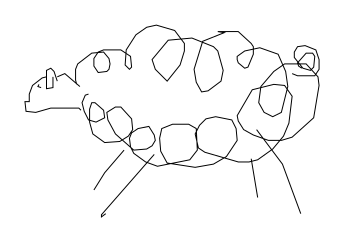

In [56]:
# get a sample drawing from the test set, and render it to .svg
# stroke = test_set.random_sample()
draw_strokes(stroke, factor=0.05)

Let's try to encode the sample stroke into latent vector $z$

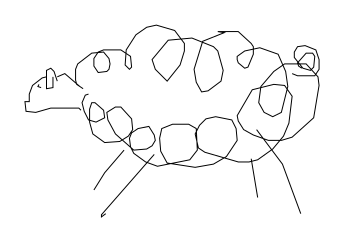

In [62]:
z = encode(stroke)

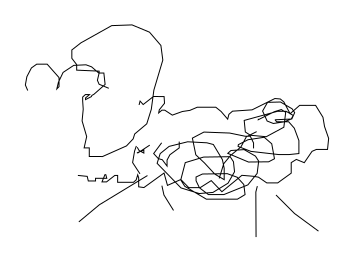

In [63]:
_ = decode(z, temperature=0.8) # convert z back to drawing at temperature of 0.8

Create generated grid at various temperatures from 0.1 to 1.0

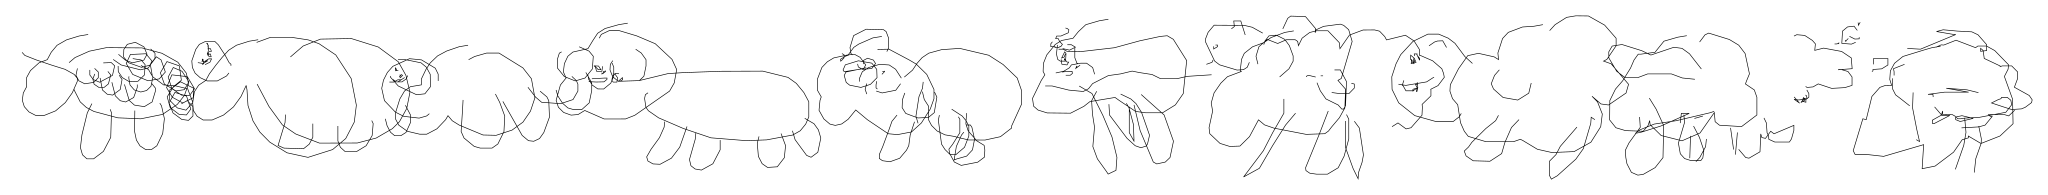

In [38]:
stroke_list = []
for i in range(10):
  stroke_list.append([decode(z, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

Latent Space Interpolation Example between $z_0$ and $z_1$

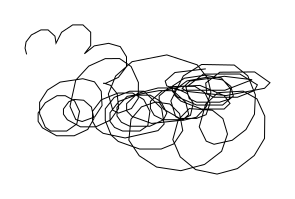

In [64]:
# get a sample drawing from the test set, and render it to .svg
z0 = z
_ = decode(z0)

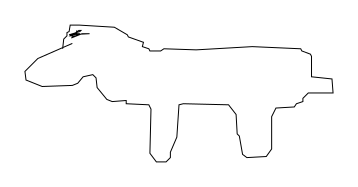

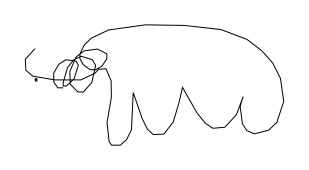

In [66]:
stroke = test_set.random_sample()
z1 = encode(stroke)
_ = decode(z1)

Now we interpolate between sheep $z_0$ and sheep $z_1$

In [67]:
z_list = [] # interpolate spherically between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z0, z1, t))

In [68]:
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False), [0, i]])

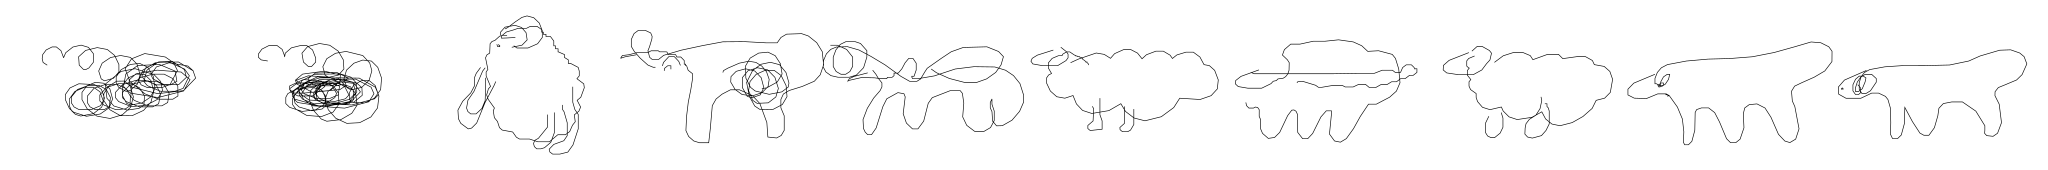

In [69]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

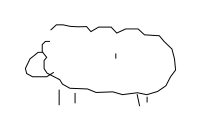

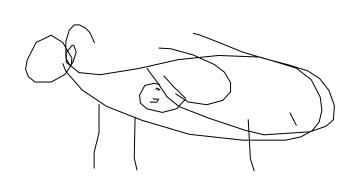

In [70]:
_ = decode(z0, temperature=0.01)
_ = decode(z1, temperature=0.01)

Let's load the Flamingo Model, and try Unconditional (Decoder-Only) Generation

In [71]:
model_dir = 'sketch_rnn/models/flamingo/lstm_uncond'

In [72]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)

In [73]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [74]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [75]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model sketch_rnn/models/flamingo/lstm_uncond/vector.
INFO:tensorflow:Restoring parameters from sketch_rnn/models/flamingo/lstm_uncond/vector


In [76]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
  reconstructions.append([decode(temperature=0.5, draw_mode=False), [0, i]])

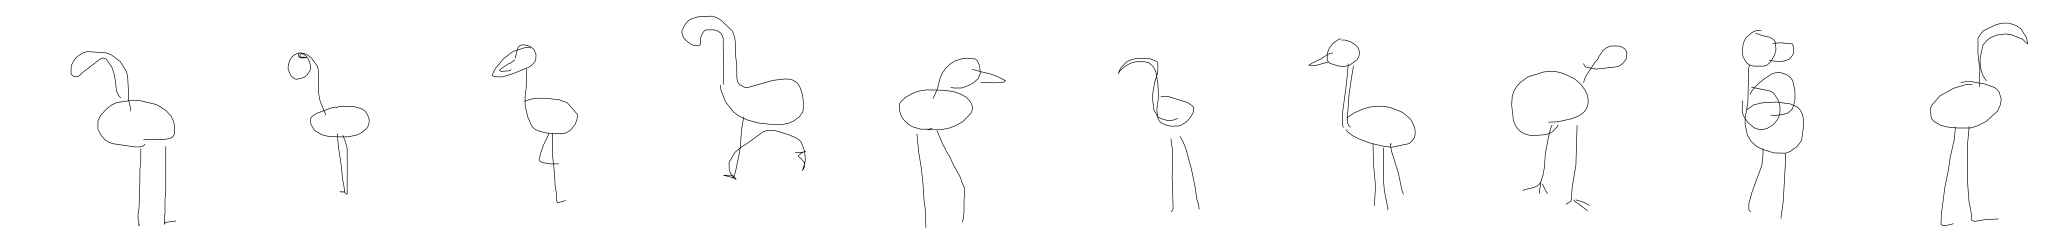

In [77]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the owl model, and generate two sketches using two random IID gaussian latent vectors

In [78]:
model_dir = 'sketch_rnn/models/owl/lstm'

In [79]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Loading model sketch_rnn/models/owl/lstm/vector.
INFO:tensorflow:Restoring parameters from sketch_rnn/models/owl/lstm/vector


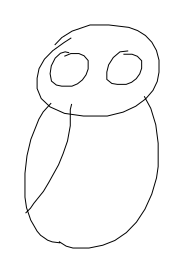

In [80]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

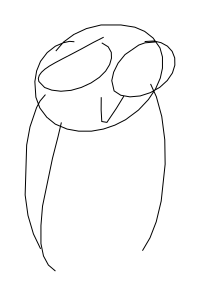

In [81]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Let's interpolate between the two owls $z_0$ and $z_1$

In [87]:
z_list = [] # interpolate spherically between z_0 and z_1
N = 20
print(len(z0), z0)
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=0.1), [0, i]])

128 [-1.006314    0.85811526  1.5668389   0.01155887 -0.11882283  0.798512   -0.39600658  0.7493407  -0.50424874  0.9882954  -0.20391443  0.5370278   1.107583    0.31510228 -2.2454896   0.59553367
  0.05095953  1.3849204  -0.12390713  0.423136   -0.75544834 -0.06600195  1.3016279  -1.8471262   1.0186212  -0.15394147  0.7424704  -0.66231143  1.3057554  -0.6225271   0.5149337   2.2429876
 -1.0180345   0.6728394   0.23680222 -1.7387527  -0.23228766  1.2803928   0.10862017  1.8266022  -0.18385604  0.85342425 -0.05096228  0.29085413 -0.00689884  0.42589122 -0.8089719   0.7232469
 -0.68131846  0.38949534  0.25738123 -0.64902353 -0.7375213   0.6977606  -0.4795364  -1.220609   -1.0455062  -0.7420533  -0.8328292   0.8116737  -0.03642725  0.17485197  0.9648217  -0.63468367
  0.8446174  -0.42474478 -1.9224159  -0.5035237   0.46121144 -0.70153487 -0.03663791  0.7278007   0.66933507  1.0476382  -2.0361404  -0.960783    0.9707789   0.24919207  0.41637912 -0.13587064
  2.3589702  -1.2904935   0.35918

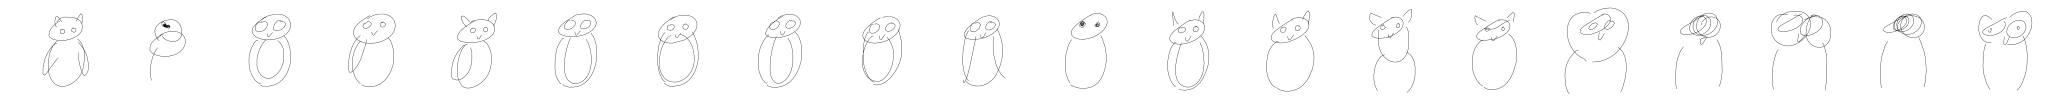

In [85]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Let's load the model trained on both cats and buses!  catbus!

In [88]:
model_dir = 'sketch_rnn/models/catbus/lstm'

In [89]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Loading model sketch_rnn/models/catbus/lstm/vector.
INFO:tensorflow:Restoring parameters from sketch_rnn/models/catbus/lstm/vector


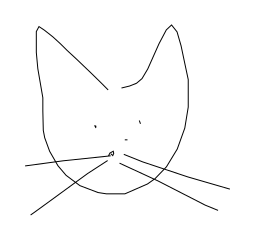

In [92]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

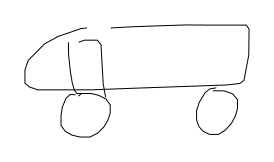

In [104]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

Let's interpolate between a cat and a bus!!!

In [125]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_1, z_0, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=1.0), [0, i]])

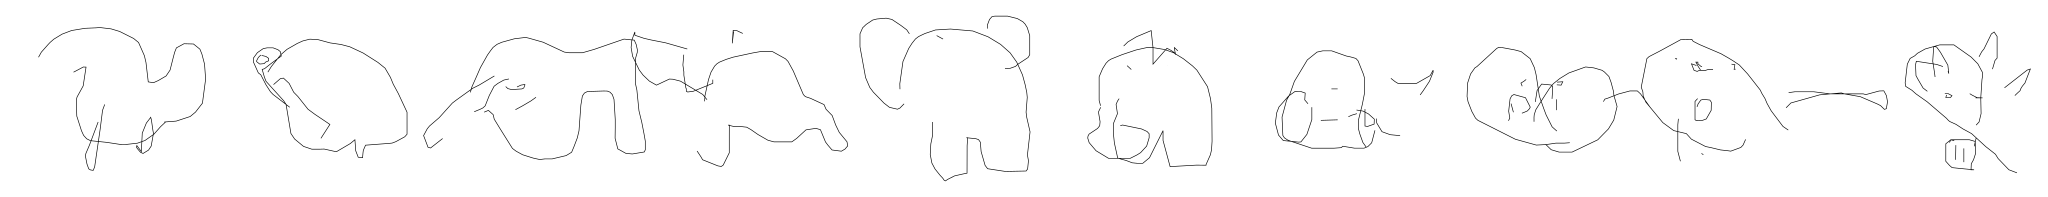

In [126]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

Why stop here? Let's load the model trained on both elephants and pigs!!!

In [107]:
model_dir = 'sketch_rnn/models/elephantpig/lstm'

In [108]:
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = False.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Loading model sketch_rnn/models/elephantpig/lstm/vector.
INFO:tensorflow:Restoring parameters from sketch_rnn/models/elephantpig/lstm/vector


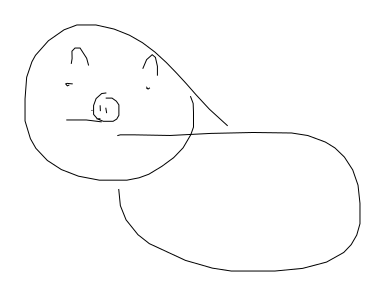

In [109]:
z_0 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_0)

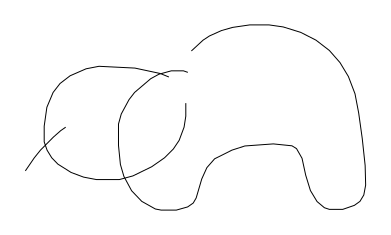

In [117]:
z_1 = np.random.randn(eval_model.hps.z_size)
_ = decode(z_1)

Tribute to an episode of [South Park](https://en.wikipedia.org/wiki/An_Elephant_Makes_Love_to_a_Pig): The interpolation between an Elephant and a Pig

In [130]:
z_list = [] # interpolate spherically between z_1 and z_0
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature=1.0), [0, i]])

In [131]:
stroke_grid = make_grid_svg(reconstructions, grid_space_x=25.0)

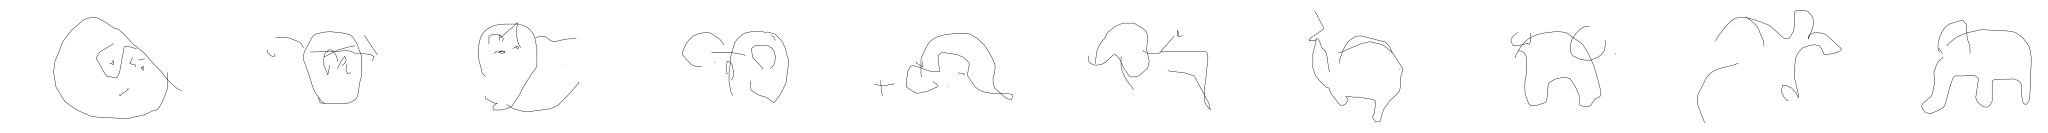

In [132]:
draw_strokes(stroke_grid, factor=0.05)